In [55]:
import pandas as pd

# Load datasets
transfers = pd.read_csv("../data/club_spending_clean.csv")
wages = pd.read_csv("../data/club_wages_clean.csv")
performance = pd.read_csv("../data/club_performance_clean.csv")
# Standardize the column name
for df in [transfers, wages, performance]:
    if "Squad" in df.columns:
        df.rename(columns={"Squad": "Club"}, inplace=True)

transfers.rename(columns={" Fee ": "TransferSpend"}, inplace=True)
wages.rename(columns={"Annual Wage": "AnnualWage"}, inplace=True)
performance.rename(columns={"Points":"Pts"}, inplace=True) 

merged = transfers.merge(wages, on=["Club","Season"], how="inner")
merged = merged.merge(performance, on=["Club","Season"], how="inner")

valid_seasons = set(transfers["Season"]) & set(wages["Season"]) & set(performance["Season"])
transfers = transfers[transfers["Season"].isin(valid_seasons)]
wages = wages[wages["Season"].isin(valid_seasons)]
performance = performance[performance["Season"].isin(valid_seasons)]

print("Merged dataset:", merged.shape)
merged.head(-1)

Merged dataset: (134, 19)


,Club,Season,TransferSpend,AnnualWage,Position,MP,W,D,L,GF,GA,GD,Pts,Pts/MP (Points per Match),xG,xGA,xGD,xGD/90,Attendance
0,Manchester City,2016-17,"£216,250,000","£137,961,000.00",3,38,23,9,6,80,39,41,78,2.05,NaN,NaN,NaN,NaN,54019
1,Manchester Utd,2016-17,"£185,000,000","£157,508,000.00",6,38,18,15,5,54,29,25,69,1.82,NaN,NaN,NaN,NaN,75290
2,Chelsea,2016-17,"£132,800,000","£98,614,000.00",1,38,30,3,5,85,33,52,93,2.45,NaN,NaN,NaN,NaN,41508
3,Arsenal,2016-17,"£113,000,000","£103,365,000.00",5,38,23,6,9,77,44,33,75,1.97,NaN,NaN,NaN,NaN,59957
4,Crystal Palace,2016-17,"£97,900,000","£72,219,000.00",14,38,12,5,21,50,63,-13,41,1.08,NaN,NaN,NaN,NaN,25161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,Bournemouth,2022-23,"£82,350,000","£38,428,000.00",15,38,11,6,21,37,71,-34,39,1.03,38.5,63.8,-25.3,-0.67,10362
129,Fulham,2022-23,"£76,100,000","£54,340,000.00",10,38,15,7,16,55,53,2,52,1.37,46.2,63.6,-17.4,-0.46,23746
130,Brighton,2022-23,"£55,700,000","£38,376,000.00",6,38,18,8,12,72,53,19,62,1.63,73.3,50.2,23.1,0.61,31477
131,Brentford,2022-23,"£48,250,000","£32,136,000.00",9,38,15,14,9,58,46,12,59,1.55,56.3,48.8,7.5,0.20,17078


In [78]:
# --- Step 3: Merge Datasets (Clean Version) ---

# 1. Restrict to overlapping seasons across all datasets
valid_seasons = set(transfers["Season"]) & set(wages["Season"]) & set(performance["Season"])
transfers = transfers[transfers["Season"].isin(valid_seasons)]
wages = wages[wages["Season"].isin(valid_seasons)]
performance = performance[performance["Season"].isin(valid_seasons)]


# 2. Select essential columns from performance
perf_cols = [c for c in ["Season","Club","Pts","GF","GA","Position"] if c in performance.columns]
performance = performance[perf_cols]

# 3. Merge transfers + wages + performance (inner join = only keep matches)
master = transfers.merge(wages, on=["Club","Season"], how="inner")
master = master.merge(performance, on=["Club","Season"], how="inner")

def clean_money(col):
    return pd.to_numeric(
        col.astype(str)
           .str.replace("£","", regex=False)
           .str.replace(",","", regex=False)
           .str.strip(),
        errors="coerce"
    )

master["TransferSpend"] = clean_money(master["TransferSpend"])
master["AnnualWage"]    = clean_money(master["AnnualWage"])
master["Pts"]           = pd.to_numeric(master["Pts"], errors="coerce")
master["GF"]            = pd.to_numeric(master["GF"], errors="coerce")

# 2. Calculate key efficiency metrics
master["CostPerPoint"] = ((master["TransferSpend"] + master["AnnualWage"]) / master["Pts"]).round(2)
master["CostPerGoal"]  = (master["AnnualWage"] / master["GF"]).round(2)


# 3. Lower score = more efficient
master["EfficiencyScore"] = (
    0.7 * master["CostPerPoint"].rank(pct=True) +   # 70% weight on financial efficiency
    0.3 * master["Position"].rank(pct=True)       # 30% weight on actual league finish
    )

# Rank clubs within each season
master["EfficiencyRank"] = master.groupby("Season")["EfficiencyScore"].rank(method="min")


# 4. Preview results
master[[
    "Season","Club","Position","TransferSpend","AnnualWage","Pts",
    "CostPerPoint","CostPerGoal","EfficiencyScore","EfficiencyRank"
]].head(15)

,Season,Club,Position,TransferSpend,AnnualWage,Pts,CostPerPoint,CostPerGoal,EfficiencyScore,EfficiencyRank
0,2016-17,Manchester City,3,216250000,137961000.0,78,4541166.67,1724512.50,0.630597,15.0
1,2016-17,Manchester Utd,6,185000000,157508000.0,69,4963884.06,2916814.81,0.701493,18.0
2,2016-17,Chelsea,1,132800000,98614000.0,93,2488322.58,1160164.71,0.191791,4.0
3,2016-17,Arsenal,5,113000000,103365000.0,75,2884866.67,1342402.60,0.372388,9.0
4,2016-17,Crystal Palace,14,97900000,72219000.0,41,4149243.90,1444380.00,0.772388,19.0
5,2016-17,Leicester City,12,92100000,63701000.0,44,3540931.82,1327104.17,0.631343,16.0
6,2016-17,Everton,7,86000000,67837000.0,61,2521918.03,1094145.16,0.304478,7.0
7,2016-17,Tottenham,2,82400000,71214000.0,86,1786209.30,828069.77,0.108209,1.0
8,2016-17,Liverpool,4,79900000,91686000.0,76,2257710.53,1175461.54,0.190672,3.0
9,2016-17,West Ham,11,70800000,56552000.0,45,2830044.44,1203234.04,0.453731,13.0


/var/folders/dh/gk8wsfcs4bl01bckq7v0_s5m0000gn/T/ipykernel_15528/3750578842.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_df, x="Club", y="CostPerPoint", palette="viridis")


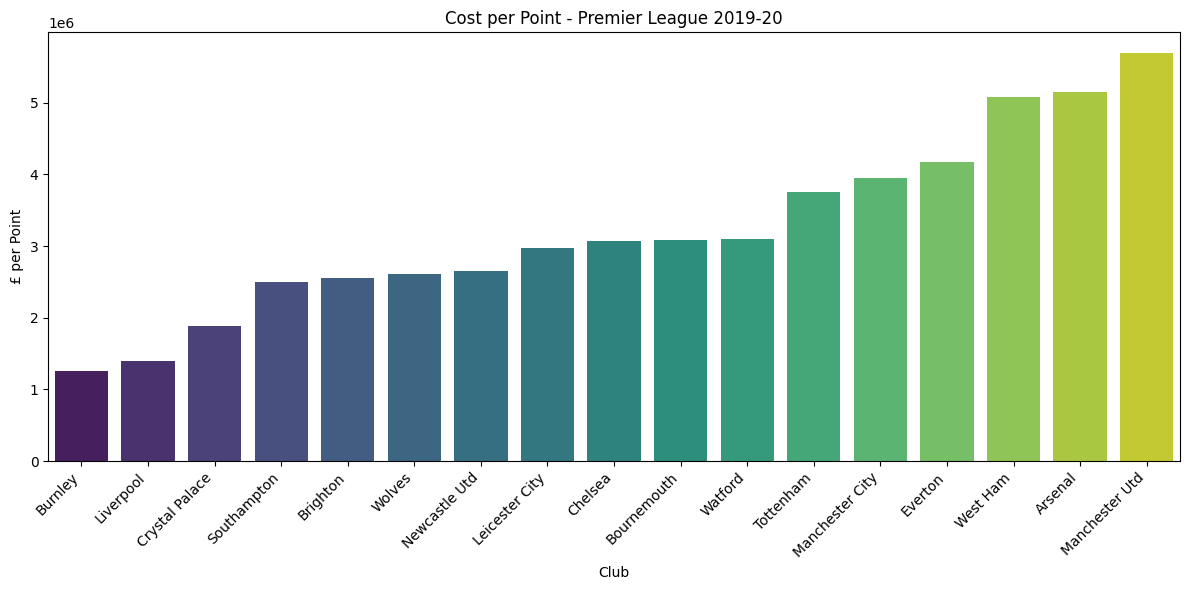

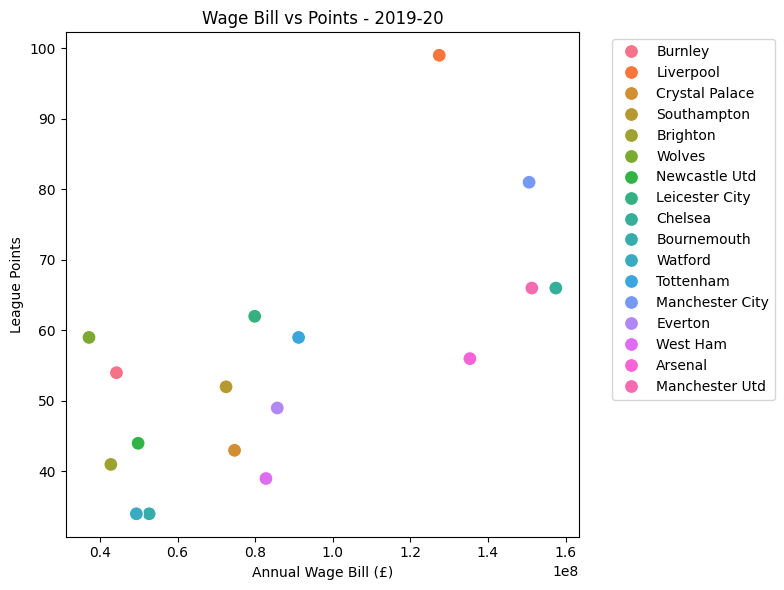

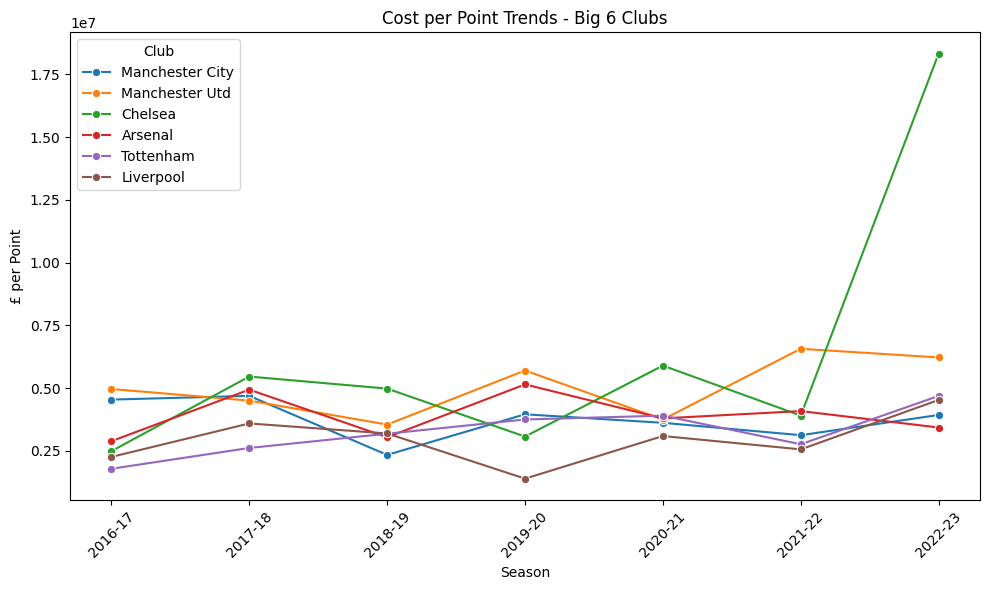

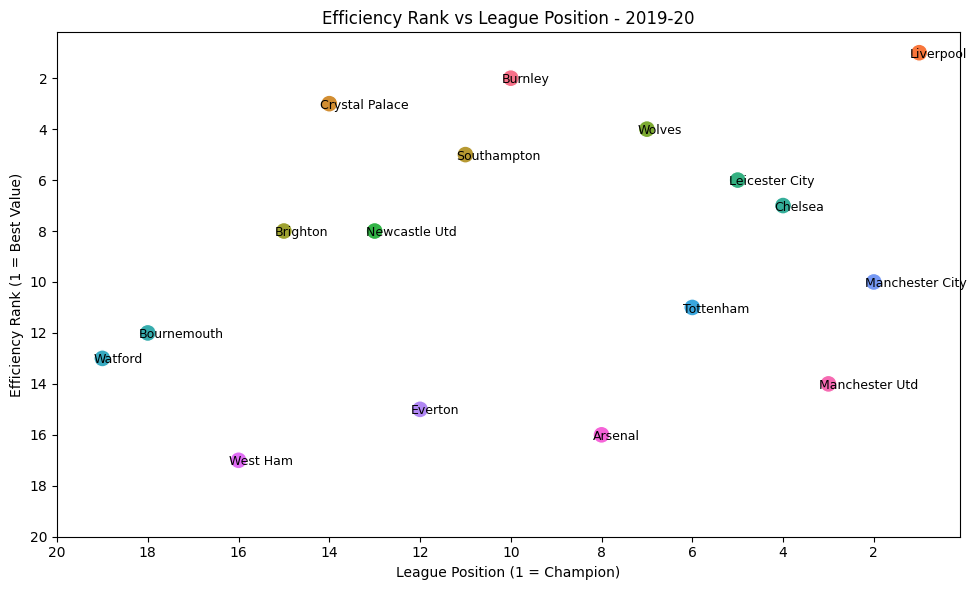

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure charts directory exists
import os
os.makedirs("../charts", exist_ok=True)

# Pick a season to visualize
season = "2019-20"
season_df = master[master["Season"] == season].sort_values("CostPerPoint")

# --- Chart 1: Cost per Point by Club (Bar Chart) ---
plt.figure(figsize=(12,6))
sns.barplot(data=season_df, x="Club", y="CostPerPoint", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title(f"Cost per Point - Premier League {season}")
plt.ylabel("£ per Point")
plt.tight_layout()
plt.savefig("../charts/cost_per_point.png")
plt.show()

# --- Chart 2: Wage Bill vs Points (Scatterplot) ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=season_df, x="AnnualWage", y="Pts", hue="Club", s=100)
plt.title(f"Wage Bill vs Points - {season}")
plt.xlabel("Annual Wage Bill (£)")
plt.ylabel("League Points")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig("../charts/wage_vs_points.png")
plt.show()

# --- Chart 3: Efficiency Trends (Line Chart over time for Big 6) ---
big6 = ["Manchester City","Manchester Utd","Arsenal","Chelsea","Liverpool","Tottenham"]
big6_df = master[master["Club"].isin(big6)]

plt.figure(figsize=(10,6))
sns.lineplot(data=big6_df, x="Season", y="CostPerPoint", hue="Club", marker="o")
plt.title("Cost per Point Trends - Big 6 Clubs")
plt.ylabel("£ per Point")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../charts/big6_cost_per_point_trends.png")
plt.show()

# --- Chart 4: EfficiencyRank vs League Position ---
import matplotlib.ticker as ticker

plt.figure(figsize=(10,6))
sns.scatterplot(data=season_df, x="Position", y="EfficiencyRank", hue="Club", s=150, legend=False)

# Annotate clubs
for i, row in season_df.iterrows():
    plt.text(row["Position"]+0.2, row["EfficiencyRank"]+0.2, row["Club"], fontsize=9)

plt.title(f"Efficiency Rank vs League Position - {season}")
plt.xlabel("League Position (1 = Champion)")
plt.ylabel("Efficiency Rank (1 = Best Value)")

# Force axes to show whole numbers and full 1–20 range
plt.xticks(range(1,21))
plt.yticks(range(1,21))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Invert so 1st place is top-left
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("../charts/efficiency_vs_position.png")
plt.show()